In [16]:
import _pickle as pickle
from numpy.lib.stride_tricks import as_strided
from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
# Common, File Based, and Math Imports
import pandas as pd
import numpy as np
import collections
import os
import librosa
import soundfile
from os.path import isdir, join
from pathlib import Path
from subprocess import check_output
import sys
import math
import pickle
from glob import glob
import random
from random import sample
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.lib.stride_tricks import as_strided
from tqdm import tqdm

# Audio processing
from scipy import signal
from scipy.fftpack import dct
import soundfile
import json
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from scipy.fftpack import fft

# Neural Network
import keras
from keras.models import Model
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras import regularizers, callbacks
from keras.constraints import max_norm
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Lambda, Dense, Dropout, Flatten, Embedding,Activation, GRUCell, LSTMCell,SimpleRNNCell
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, Conv1D, SimpleRNN, GRU, LSTM, CuDNNLSTM, CuDNNGRU, Conv2D
#from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU
from keras.layers import LeakyReLU, PReLU, ThresholdedReLU, ELU
from keras.layers import BatchNormalization, TimeDistributed, Bidirectional
#from keras.layers import activations, Wrapper
from keras.regularizers import l2
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from keras import constraints, initializers, regularizers
#from keras.engine.topology import Layer
import keras.losses
#from keras.backend.tensorflow_backend import set_session
#from keras.engine import InputSpec
import tensorflow as tf

# Model metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import IPython.display as ipd
from IPython.display import Markdown, display, Audio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)
color = sns.color_palette()
sns.set_style('darkgrid')
py.init_notebook_mode(connected=True)
%matplotlib inline

# Setting Random Seeds
np.random.seed(95)
RNG_SEED = 95

### Defining some initial functions for preparing the dataset

In [21]:
supported = """
ሀ ሁ ሂ ሄ ህ ሆ
ለ ሉ ሊ ላ ሌ ል ሎ ሏ
መ ሙ ሚ ማ ሜ ም ሞ ሟ
ረ ሩ ሪ ራ ሬ ር ሮ ሯ
ሰ ሱ ሲ ሳ ሴ ስ ሶ ሷ
ሸ ሹ ሺ ሻ ሼ ሽ ሾ ሿ
ቀ ቁ ቂ ቃ ቄ ቅ ቆ ቋ
በ ቡ ቢ ባ ቤ ብ ቦ ቧ
ቨ ቩ ቪ ቫ ቬ ቭ ቮ ቯ
ተ ቱ ቲ ታ ቴ ት ቶ ቷ
ቸ ቹ ቺ ቻ ቼ ች ቾ ቿ
ኋ
ነ ኑ ኒ ና ኔ ን ኖ ኗ
ኘ ኙ ኚ ኛ ኜ ኝ ኞ ኟ
አ ኡ ኢ ኤ እ ኦ
ኧ
ከ ኩ ኪ ካ ኬ ክ ኮ
ኳ
ወ ዉ ዊ ዋ ዌ ው ዎ
ዘ ዙ ዚ ዛ ዜ ዝ ዞ ዟ
ዠ ዡ ዢ ዣ ዤ ዥ ዦ ዧ
የ ዩ ዪ ያ ዬ ይ ዮ
ደ ዱ ዲ ዳ ዴ ድ ዶ ዷ
ጀ ጁ ጂ ጃ ጄ ጅ ጆ ጇ
ገ ጉ ጊ ጋ ጌ ግ ጐ ጓ ጔ
ጠ ጡ ጢ ጣ ጤ ጥ ጦ ጧ
ጨ ጩ ጪ ጫ ጬ ጭ ጮ ጯ
ጰ ጱ ጲ ጳ ጴ ጵ ጶ ጷ
ፀ ፁ ፂ ፃ ፄ ፅ ፆ ፇ
ፈ ፉ ፊ ፋ ፌ ፍ ፎ ፏ
ፐ ፑ ፒ ፓ ፔ ፕ ፖ
""".split()

char_map = {}
char_map[""] = 0
char_map["<SPACE>"] = 1
index = 2
for c in supported:
    char_map[c] = index
    index += 1
index_map = {v+1: k for k, v in char_map.items()}

In [22]:
# Function for calculating feature dimensions.
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

### Defining the primary class for preparing the dataset for visualization and modeling.

Defining the primary class for preparing the dataset for visualization and modeling.
This class provides options for training models on both MFCC's and Spectrograms of the data but is set to use spectrograms by default.

In [31]:
class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        # Initializing variables
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
    # Obtain a batch of audio files
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. Must be train/validation/test")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # Calculate size
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # Initialize arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # Calculate input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # Calculate label_length
            label = np.array(text_to_int_seq(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)

        # Output arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_dataset_by_partition(self, partition):
    # More shuffling
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_dataset(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_dataset(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

    def sort_dataset_by_duration(self, partition):
    # Extra shuffling
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_dataset(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_dataset(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

    def next_train(self):
    # Get a batch of training data
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_dataset_by_partition('train')
            yield ret    

    def next_valid(self):
    # Get a batch of validation data
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_dataset_by_partition('valid')
            yield ret

    def next_test(self):
    # Get a batch of testing data
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret
            
    # Load datasets
    def load_train_data(self, desc_file='../data/train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_dataset_by_duration('train')
                

    def load_validation_data(self, desc_file='../data/test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_dataset_by_duration('valid')

    def load_test_data(self, desc_file='../data/test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
        if self.sort_by_duration:
            self.sort_dataset_by_duration('test')
            
    def load_metadata_from_desc_file(self, desc_file, partition):
    # Get metadata from json corpus
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
    # Estimate descriptive stats for training set based on sample of 100 instances
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
    # Create features from data, either spectrogram or mfcc
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
    # Scale the data to improve neural network performance and reduce the size of the gradients
        return (feature - self.feats_mean) / (self.feats_std + eps)

### Acoustic Feature Extraction/Engineering for Speech Recognition

The primary dataset used will not need much cleaning as it is taken from audiobooks that have been preprocessed for background noises. This will, of course, lead to reduced performance in distracting environments.

In [32]:
# Defining 3 different ways of converting audio files to spectrograms

def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
# Create a spectrogram from audio signals
    assert not np.iscomplexobj(samples), "You shall not pass in complex numbers"
    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)  
    scale = window_norm * sample_rate
    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]
    # Reshape to include the overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)
    # Window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])
    # Broadcast window, and then compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2
    # Scale 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale
    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])
    return x, freqs

def spectrogram_from_file(filename, step=10, window=20, max_freq=None, eps=1e-14):
# Calculate log(linear spectrogram) from FFT energy
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq can not be > than 0.5 of "
                             " sample rate")
        if step > window:
            raise ValueError("step size can not be > than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

def log_spectrogram_feature(samples, sample_rate, window_size=20, step_size=10, eps=1e-14):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(samples,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    freqs = (freqs*2)
    return freqs, times, np.log(spec.T.astype(np.float64) + eps)

### Visualizing The Data

1. Raw Audio
2. Spectrograms
3. Mel-Frequency Cepstral Coefficients

In [33]:
def vis_train_features(index):
# Function for visualizing a single audio file based on index chosen
    # Get spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # Get mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # Obtain text label
    vis_text = audio_gen.train_texts[index]
    # Obtain raw audio
    sample_rate, samples = wav.read(vis_audio_path)
    # Print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # Return labels for plotting
    return vis_text, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path, sample_rate, samples

In [34]:
# Creating visualisations for audio file at index number 2012
vis_text, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path, sample_rate, samples, = vis_train_features(index=2012)

There are 9339 total training examples.


### Raw Audio
This method uses the raw wave forms of the audio files and is a 1D vector of the amplitude where X = [x1, x2, x3...]

This is used by the Pannous Sequence to Sequence models built in Caffe and TensorFlow.

In [35]:
def plot_raw_audio(sample_rate, samples):
    # Plot the raw audio signal
    time = np.arange(0, float(samples.shape[0]), 1) / sample_rate
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    ax.plot(time, samples, linewidth=1, alpha=0.7, color='#76b900')
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

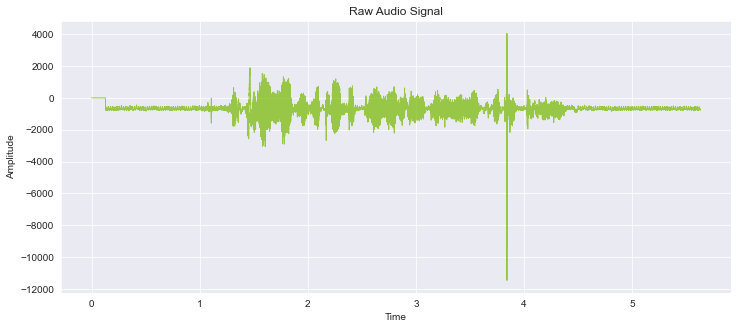

**Audio File Transcription** :  ኤርትራ ና ጅቡቲ ዲፕሎማሲ ያዊ ግንኙነት ሊ ቀጥሉ ነው 

In [36]:
# Plot the raw audio file
plot_raw_audio(sample_rate, samples)
# Print the transcript corresponding to the audio file
display(Markdown('**Audio File Transcription** : ' + str(vis_text)))
# Play the raw audio file
Audio(vis_audio_path)